# Basic image processing techniques

This notebook contains several imagie processing techniques implemented in python either from scratch, using a pckage or both. First step in a long journey.


In [278]:
#necessary packages
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from os import walk, path
from tqdm import tqdm
import scipy.signal as sig
from scipy.ndimage import filters
from scipy.ndimage import measurements,morphology

## Conversion to grayscale

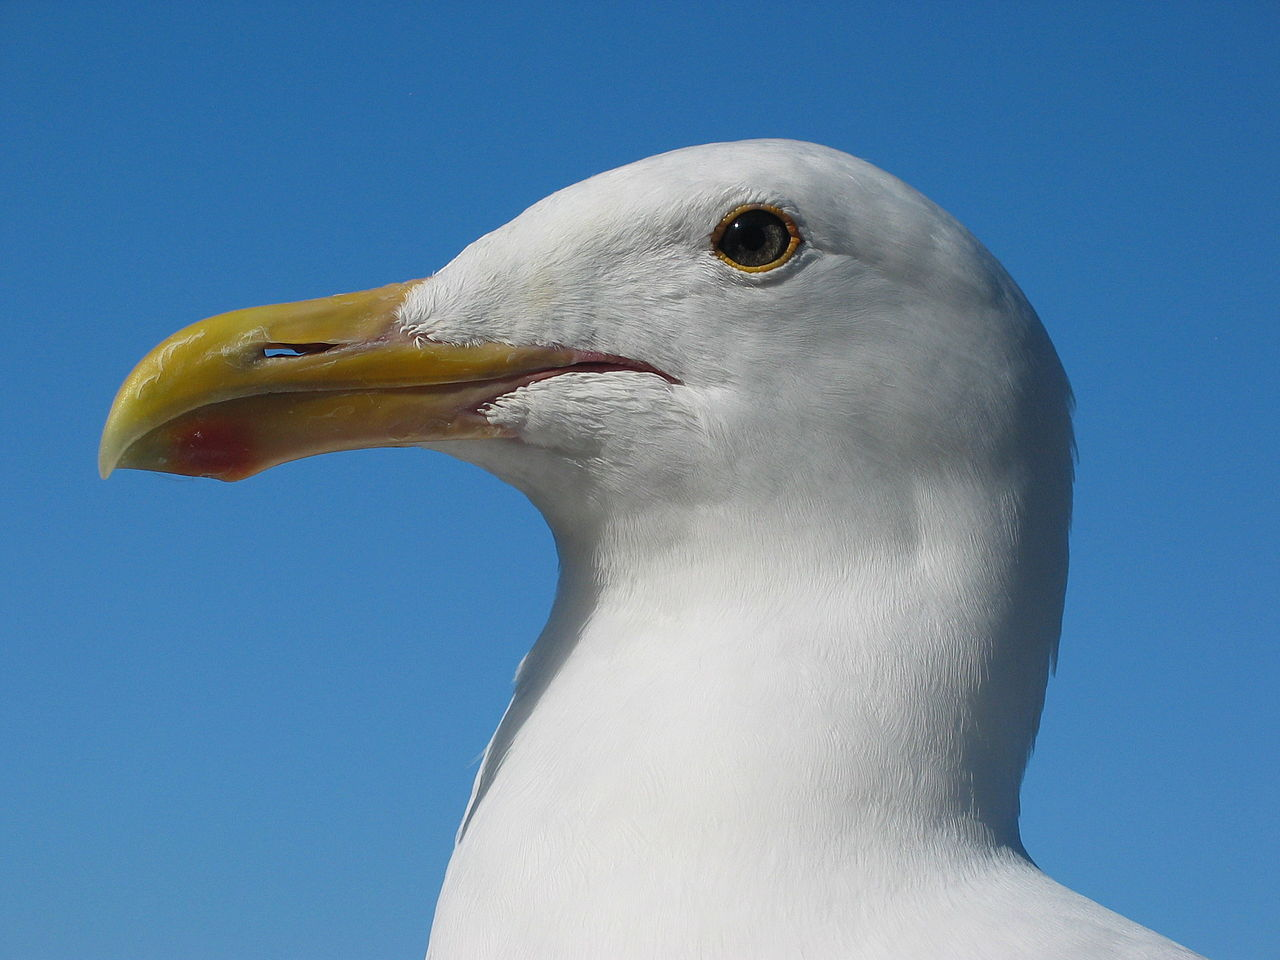

In [8]:
#Let's read an image in RGB mode and convert it into gray scale manually
# we will use PIL for reading images, feel free to use any you want
# Let's torture this proud seagull
img = Image.open('./images/seagull.jpg')
img #Well that's one big proud seagull let's resize it

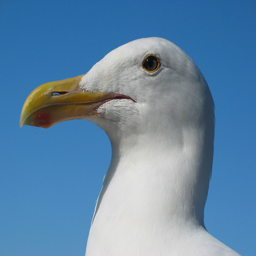

In [11]:
img_rsz = img.resize((256, 256))
img_rsz

There, now that's a more manageable seagull. We will tackle resizing later as dealing with it is kind of headache for now thoight it isn't remotely hard.

Here we will use the weighted method, though averaging is okay, YUV and HSV are also a possibility. As all of them are just summing values, any of them is valid from a 'difficulty' view point. The weighted method average the RGB values according to their wavelengths. The formula is : $ Y = 0.2989 R + 0.5870 G + 0.1140 B$

In [12]:
img_np = np.array(img_rsz)

In [13]:
img_np.shape

(256, 256, 3)

Now, we can see that the image has similar height and width and 3 channels : red, green and blue

In [14]:
img_gray = 0.2989*img_np[:,:,0]+0.5870*img_np[:,:,1]+0.1140*img_np[:,:,2] 

In [15]:
img_gray

array([[ 85.7715,  86.2553,  88.326 , ...,  82.9244,  82.9352,  82.6471],
       [ 87.3261,  88.1411,  88.9561, ...,  84.8102,  83.6362,  83.647 ],
       [ 88.081 ,  89.141 ,  89.027 , ...,  83.7394,  83.3373,  83.8211],
       ...,
       [128.8614, 130.8612, 130.1602, ..., 125.7199, 126.0188, 126.2037],
       [129.4376, 130.1494, 130.1602, ..., 125.7091, 125.535 , 124.6599],
       [129.8613, 129.1603, 131.1709, ..., 125.8231, 125.535 , 124.5459]])

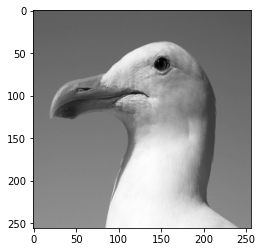

In [38]:
plt.imshow(img_gray, cmap='gray');

In [32]:
# Let's read the image using PIL and convert it to gray simultaneously
# The code is not optimised but that is not the goal here
img_2 = Image.open('./images/seagull.jpg')
img_2 = img_2.resize((256, 256))
img_2_gr = img_2.convert('L')
img_2_gr = np.array(img_2_gr)


In [33]:
img_2_gr

array([[ 86,  86,  88, ...,  83,  83,  83],
       [ 87,  88,  89, ...,  85,  84,  84],
       [ 88,  89,  89, ...,  84,  83,  84],
       ...,
       [129, 131, 130, ..., 126, 126, 126],
       [129, 130, 130, ..., 126, 126, 125],
       [130, 129, 131, ..., 126, 126, 125]], dtype=uint8)

Well it looks similar, let's chech it using numpy 

In [34]:
np.allclose(img_gray, img_2_gr, atol = 1e3)

True

Close enough. Now let's torture the seagull by messing with the image, we will apply an inversiona and then some transformations

In [35]:
inv = 255 - img_gray #invert image
clamped = (100.0/255) * img_gray + 100  #clamp to interval 100...200
squared = 255.0 * (img_gray/255.0)**2 #squared

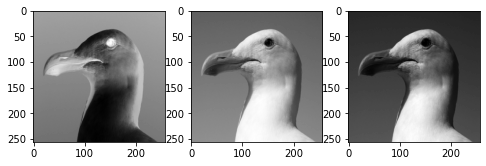

In [43]:
columns = 3
rows = 1
img_list = [inv, clamped, squared]
fig=plt.figure(figsize=(8, 8))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1], cmap='gray')
plt.show()

D'ont show the first one to your kids

## Historgram equalization

Historgram equalization is used to enhance images with high contrast, let's implement it here (the name is self explanatory, make the historgram resembles that of a uniform distiribution). We will work on the squared image. 

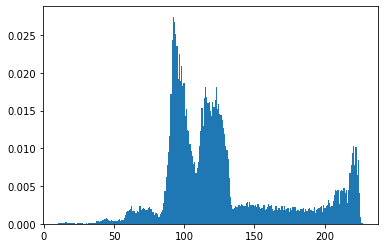

In [47]:
#visualise the histogram first
_ = plt.hist(img_gray.flatten(), bins=255, density = True)

That's a very misbehaving histogram. let's flatten it. Let's compute the comulative historgram.

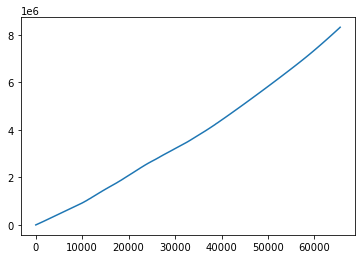

In [48]:
_ = plt.plot(np.cumsum(img_gray.flatten()))

the folowing explanation is taken from the excellent course of Alasdair Newson at Telecom Paris.
>We will now impose a contarst change on the image. A contrast change means we do not change the order of the __values__ of the pixels. We are going to use the histogram as a type of lookup table to find the new values of the image.

>In practice, this can be done with the following method :

>- normalise the cumulative histogram such that the largest value is 1.0. This will map the final image to the interval $0, \dots, 1$ (you will still have a discrete list of values, but floating point ones)
>- convert the image grey-levels back to the interval $\{0, \dots 255\}$ as int values. This will allow us to use these values as indices in H
>- apply the cumulative histogram to the values of the image pixels

In [49]:
def equalize_histogram(img_in):
    hist = np.cumsum(np.histogram(img_in.flatten(), bins=256)[0])
    hist = (hist - hist.min()) / (hist.max() - hist.min())
    img_rescale = ((img_in - img_in.min()) * (1/(img_in.max() - img_in.min()) * 255)).astype('uint8')
    img_equalise = hist[img_rescale]
    return img_equalise

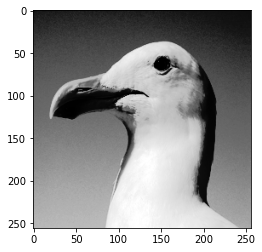

In [53]:
equalized = equalize_histogram(squared)
plt.imshow(equalized, cmap='gray');

Now that's a more hellish seagull. let's take a look at the histogram

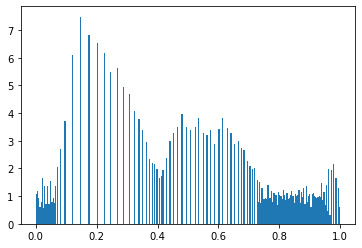

In [54]:
_ = plt.hist(equalized.flatten(), bins=255, density = True)

It is better spread now

Let's see how another function does, coded by Jan Erik Solem in his book ``Programming Computer Vision
with Python``

In [61]:
def histeq(im,nbr_bins=256):
    """ Histogram equalization of a grayscale image. """
    # get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins)
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize
    # use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape), cdf

In [62]:
equalized_2, _ = histeq(squared)

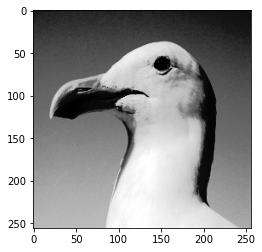

In [63]:
plt.imshow(equalized_2, cmap='gray')

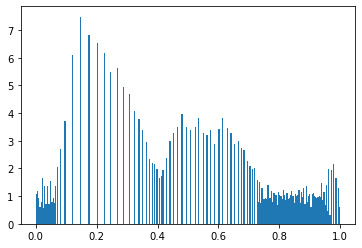

In [64]:
_ = plt.hist(equalized.flatten(), bins=255, density = True)

Pretty much the same.

## Averaging images and PCA 

Averagng images can be useful in some artistic effects or to reduce a type of noise if the same image is available in multiple iterations. Using pandas averaging images is pretty straightforward. PCA on the otehr hand is a dimension reduction technique that reduces the dimension of the data to a lower space in which a good propertion of the information (explained variance) is still there. Our goal here is not to explain nor implement PCA but to use it on images and see how that goes.

In [5]:
# Let's code an image averaging function that takes a path and the desired image size
def avg_img_func(img_path, size=(256,256)):
    _, _, filenames = next(walk(img_path)) #list all files in a dir
    avg_mat = np.zeros(size) # empty matrix
    for filename in filenames:
        try:
            temp = Image.open(path.join(img_path, filename)).convert('L') #gray level for now but works for RGB images too
            avg_mat += np.array(temp.resize(size))
        except (RuntimeError, TypeError, NameError):
            print('Eh dude I encountered an error in file {}'.format(filename))
    return avg_mat/len(filenames)

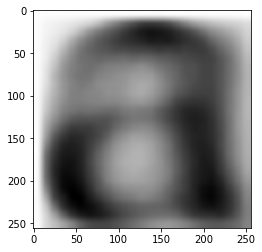

In [6]:
avg_img = avg_img_func('./images/fontimages/a_thumbs')
plt.imshow(avg_img, cmap='gray');

We can see the average image here which more or less have this blurry effect. Now we are ready to apply PCA. We will first put all the data in a matrix by stacking the images, converted in row format and then subtracting the mean image from each of them and then use SVD to determine pricipal components. At this point we are followung the steps of Jan Erik Solem, since we will refer to his book throughout this prioject let's call him just Eric.

In [37]:
def stck_img_func(img_pth, size=(256, 256)):
    _, _, filenames = next(walk(img_pth)) #list all files in a dir
    avg_mat = np.zeros(size)
    for idx, filename in enumerate(tqdm(filenames)): #visualise progress, i got tired of waiting
        try:
            temp = Image.open(path.join(img_pth, filename)).convert('L')
            if idx == 0:
                stacked = np.array(temp.resize(size)).flatten('F') #fortran style flattening
            else:
                stacked = np.vstack((stacked, np.array(temp.resize(size)).flatten('F')))
            
        except (RuntimeError, TypeError, NameError):
            print('Eh dude I encountered an error in file {}'.format(filename))
        
    return stacked


In [38]:
stack_img = stck_img_func('./images/fontimages/a_thumbs')

100%|██████████████████████████████████████████████████████████████████████████████| 2359/2359 [00:40<00:00, 58.28it/s]


In [39]:
# Let's see what is the shape of the final matrix, it should be 2359, 65536
stack_img.shape #hooray now pca

(2359, 65536)

The function below performs PCA and return the projection matrix (with important dimensions first), variance and mean. Taken from our dear Eric. 

In [52]:
def pca(data_mat, mean_data=None):
    rows, cols = data_mat.shape
    if mean_data is None:
        mean_data = np.mean(data_mat, axis=0)
    data_mat = data_mat - mean_data
    # Trick by Eric
    if cols>rows:
    # PCA - compact trick used
        cov_mat = data_mat.dot(data_mat.T) # covariance matrix
        eig_val, eig_vec = np.linalg.eigh(cov_mat) # eigenvalues and eigenvectors
        temp = np.dot(data_mat.T,eig_vec).T # The trick, magic
        V = temp[::-1] # reverse since last eigenvectors are the ones we want
        S = np.sqrt(eig_val)[::-1] # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = np.linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
        # return the projection matrix, the variance and the mean
    return V, S, mean_data

In [53]:
# Let's perform PCA
V, S, mean_data = pca(stack_img, avg_img.flatten('F'))
# a warning might appear but it is not serious, you can opt to omit warnings but that is a bad practice

<ipython-input-52-68c31e47b3c7>:13: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(eig_val)[::-1] # reverse since eigenvalues are in increasing order


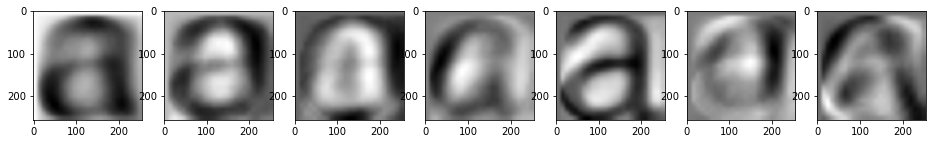

In [57]:
columns = 7
rows = 1
size=(256, 256)
img_list = [np.reshape(V[i], size,order='F') for i in range(7)]
img_list.insert(0, avg_img)
fig=plt.figure(figsize=(16, 8))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1], cmap='gray')
plt.show()

We can see that the first 7 modes retain a lot of information about the data, especially the first one. At least now we can visually understand the concept of explained variance. 4th mode looks good.

## Image blurring

I mage blurring, simply enough is the act of blurring an image, shocking i know. Here we will employ gaussian blurring, this mean that the filter kernel is gaussian taking its name from the gaussian probability distribution (a glorified exponentiel). We can use scipy for this but where is the fun in this so let's do it manually. Now blurring can be done through a convolution in the time space and via a multiplication in the fourrier one that's why fourrier transform comes in handy. However since we are very masochistic here we will manually program convolution and apply it rather than using scipy. Let's start with convolution first. (2D convolution to be exact, though 1D and 3D ones are also possible).

In [232]:
def conv(data, kernel, mode='full', boundary='fill', fill_value=0):
    # let's first check that the dimension of the inputs match
    assert data.ndim == kernel.ndim, "The number of dimensions of inputs must match"
    assert mode in ['full', 'same', 'valid'], "The mode must be one of the following : full, same or valid"
    assert boundary in ['fill', 'wrap', 'same'], "The boundary must be one of the following : fill, wrap, symm"
    (rows, cols), (rker, cker) = data.shape, kernel.shape
    x_min, x_max, y_min, y_max = rker//2, rows-rker//2, cker//2, cols-cker//2
    if mode=='valid':
        res = np.empty((rows - rker//2, cols - cker//2))
        for x in range(x_min, x_max+1):
            for y in range(y_min, y_max+1): 
                res[x-x_min, y-y_min] = np.sum(np.multiply(data[x-x_min:x+rker-x_min, y-y_min:y+cker-y_min], kernel))
    else:
        res=None
    return res

## Image derivatives

Image derivates usually serve for edge detection purposes. They can be computed using the finite difference method and then store the coefficients in matrix conveniently called : gradient operator matrix. One the matrix is computed a simple convolution with the image would reveal the edges. Two gradient operators are required to detect all directions of the edges (x, and y). In some cases, like Total variation method (will see it later), one needs to compute the 2nd order derivates too to get a more accurate result. Some of the most well known operators include the sobel operator, Perwitt, Canny, ... Here we will take a look at the first two.
 
Note: this is a very broad description and the reader is encouraged to auto-inform on the matter, again our goal here is not to get into the mathematical details of these operation but to explore them and have a bit of fun trying to implementing similar approaches. In a future project we will explore all these and more in a dedicated entries. 

Here we will limit ourselves to first order derivatives so a 3*3 matrices for both filters.

In [241]:
Sobel_x = np.matrix([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
Sobel_y = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
Perwitt_x = np.matrix([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
Perwitt_y = np.matrix([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

This will only take a gray scale image so one channel, for muulti channel image repeat same process on all channels.

In [248]:
def edge_detect(img, method='Sobel'):
    assert method in ['Sobel', 'Perwitt'], 'Only Sobel operators and Perwitt ones are implemented for now'
    assert img.ndim==2, 'Please convert image to gray scale'
    if method=='Sobel':
        dx = np.matrix([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
        dy = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    else:
        dx = np.matrix([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
        dy = np.matrix([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    img_x = sig.convolve2d(img, dx, mode='same', boundary='fill', fillvalue=0)
    img_y = sig.convolve2d(img, dy, mode='same', boundary='fill', fillvalue=0)
    img_mag = np.sqrt(np.power(img_x, 2) + np.power(img_y, 2))
    img_x = 255 * (img_x - np.min(img_x))/(np.max(img_x - np.min(img_x)))
    img_y = 255 * (img_y - np.min(img_y))/(np.max(img_y - np.min(img_y)))
    img_mag = 255 * (img_mag - np.min(img_mag))/(np.max(img_mag - np.min(img_mag)))
    return img_x, img_y, img_mag

In [249]:
img_in = np.array(Image.open('./images/empire.jpg').convert('L'))
img_x, img_y, img_mag = edge_detect(img_in)

Let's plot the results 

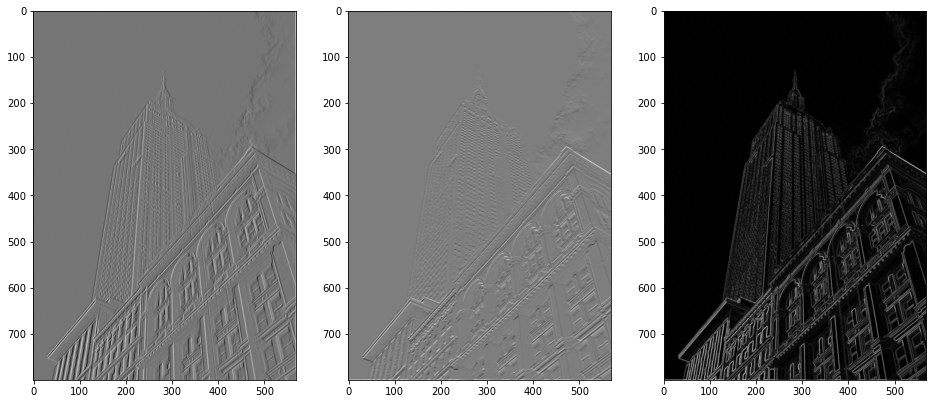

In [250]:
columns = 3
rows = 1
img_list = [img_x, img_y, img_mag]
fig=plt.figure(figsize=(16, 8))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1], cmap='gray')
plt.show()

This seems good and all but our dear Eric notes the following drawback (I trust him, he seems to know what he is doing, cool guy) : 
>Using this approach has the drawback that derivatives are taken on the scale determined by the image resolution.  

What he suggest is a more robust method to noise and scale, this comes in the form of gaussian drivatives.

In [261]:
def gaussian_filter_grads(img_shape, sigma):
    x, y = np.arange(0, img_shape[0], 1), np.arange(0, img_shape[1], 1)
    x, y = np.meshgrid(x, y)
    g_x = np.multiply(img_shape[0]/2 - x, np.exp(-(((x-img_shape[0]/2)**2 + (y-img_shape[1]/2)**2) / (2*sigma**2)))) / (2*np.pi*sigma**4)
    g_y = np.multiply(img_shape[1]/2 - y,  np.exp(-(((x-img_shape[0]/2)**2 + (y-img_shape[1]/2)**2) / (2*sigma**2)))) / (2*np.pi*sigma**4)
    return g_x, g_y

Let's incorporate them into the previous function.

In [262]:
def edge_detect(img, method='Sobel', sigma=1):
    assert method in ['Sobel', 'Perwitt', 'Gaussian'], 'Only Sobel, Gaussian and Perwitt operators are implemented for now'
    assert img.ndim==2, 'Please convert image to gray scale'
    if method=='Sobel':
        dx = np.matrix([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
        dy = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    elif method=='Gaussian':
        dx, dy = gaussian_filter_grads(img.shape, sigma)
        print(done)
    else:
        dx = np.matrix([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
        dy = np.matrix([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    img_x = sig.convolve2d(img, dx, mode='same', boundary='fill', fillvalue=0)
    img_y = sig.convolve2d(img, dy, mode='same', boundary='fill', fillvalue=0)
    img_mag = np.sqrt(np.power(img_x, 2) + np.power(img_y, 2))
    img_x = 255 * (img_x - np.min(img_x))/(np.max(img_x - np.min(img_x)))
    img_y = 255 * (img_y - np.min(img_y))/(np.max(img_y - np.min(img_y)))
    img_mag = 255 * (img_mag - np.min(img_mag))/(np.max(img_mag - np.min(img_mag)))
    return img_x, img_y, img_mag

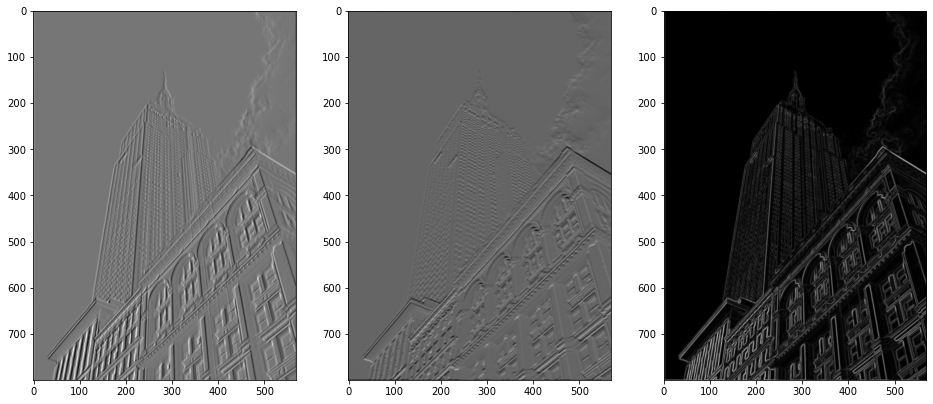

In [263]:
img_x, img_y, img_mag = edge_detect(img_in, method='Gaussian')
columns = 3
rows = 1
img_list = [img_x, img_y, img_mag]
fig=plt.figure(figsize=(16, 8))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1], cmap='gray')
plt.show()

It takes some time to compute the convolutions and that's why it is better to do it in the frequency domain where it is a simple multiplication. We will delve into this further in the next chapter as we try to implement the DFTT (discrete Fourier transform). the results appear to more pronounced but let's compare all this to scipy implementation.

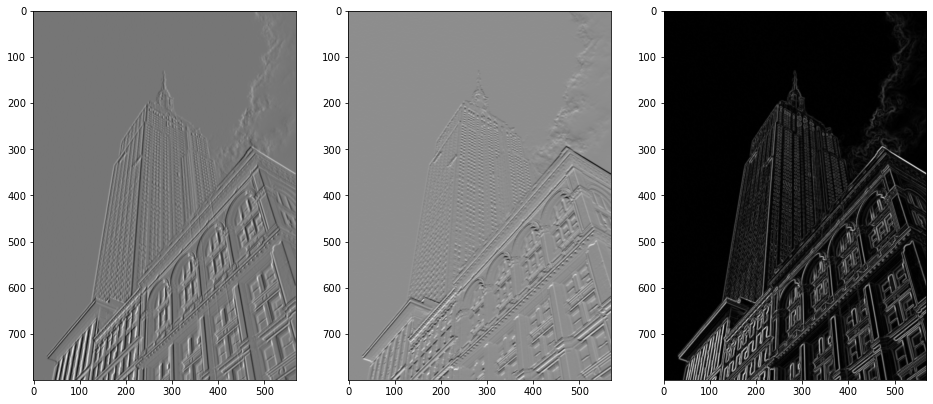

In [273]:
sigma = 1.
img_x_sci = np.zeros(img_in.shape)
filters.gaussian_filter(img_in, (sigma,sigma), (0,1), img_x_sci)
img_y_sci = np.zeros(img_in.shape)
filters.gaussian_filter(img_in, (sigma,sigma), (1,0), img_y_sci)
img_mag_sci = np.sqrt(np.power(img_x_sci, 2) + np.power(img_y_sci, 2))
columns = 3
rows = 1
img_list = [img_x_sci, img_y_sci, img_mag_sci]
fig=plt.figure(figsize=(16, 8))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1], cmap='gray')
plt.show()

That was a lot faster and results seem to be similar. 

## Binary images

Here we will take a look at binary images which, simply enough, can be created from gray scale images via thresholding. We will later take a look at more advanced segmentation techniques like otsu or region growing. 

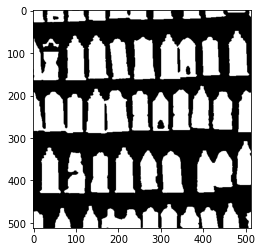

In [285]:
img_in = np.array(Image.open('./images/houses.png').convert('L'))
img_in = 1*(img_in<128)
plt.imshow(img_in, cmap='gray');

second example

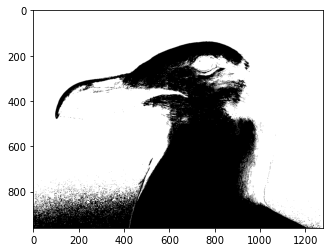

In [286]:
exp = np.array(Image.open('./images/seagull.jpg').convert('L'))
exp = 1*(exp<128)
plt.imshow(exp, cmap='gray');

# Conclusion

We will end this basic introduction here and move on to more advanced concepts like denoising and feature detection.